In [26]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import statsmodels.api as sm
from itertools import product
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [27]:
DOGE_Data = pd.read_csv("../data/DOGE_1d_price.csv")
DOGE_Data.set_index("open_time", inplace=True, drop=True)
DOGE_Data.rename(columns={"close": "Close"}, inplace=True)

In [28]:
DOGE_Data.index = pd.to_datetime(DOGE_Data.index)

In [29]:
DOGE_Data

,Unnamed: 0,open,high,low,Close,volume,close_time,quote_volume,trades,taker_base_volue,taker_quote_volume,ignore,coin
open_time,,,,,,,,,,,,,
2019-07-05,1000,0.004490,0.004600,0.003550,0.003870,1.928298e+09,1562371199999,7.506289e+06,18589,858403324.0,3.336426e+06,0,DOGE
2019-07-06,1001,0.003874,0.003943,0.003365,0.003500,1.010744e+09,1562457599999,3.692804e+06,17250,522724122.0,1.908500e+06,0,DOGE
2019-07-07,1002,0.003504,0.003650,0.003400,0.003538,5.306140e+08,1562543999999,1.860353e+06,9394,275110757.0,9.650934e+05,0,DOGE
2019-07-08,1003,0.003538,0.003562,0.003400,0.003458,3.084457e+08,1562630399999,1.078072e+06,4958,159456967.0,5.580242e+05,0,DOGE
2019-07-09,1004,0.003462,0.003582,0.003356,0.003455,2.533756e+08,1562716799999,8.785283e+05,5690,115809520.0,4.020473e+05,0,DOGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-04,995,0.079610,0.079700,0.077940,0.078380,5.216261e+08,1683244799999,4.109288e+07,76795,271015392.0,2.135256e+07,0,DOGE
2023-05-05,996,0.078370,0.081470,0.077050,0.080170,7.515606e+08,1683331199999,5.952919e+07,114228,377972788.0,2.995173e+07,0,DOGE
2023-05-06,997,0.080170,0.080490,0.075660,0.076720,8.661619e+08,1683417599999,6.722770e+07,125573,381386141.0,2.957600e+07,0,DOGE


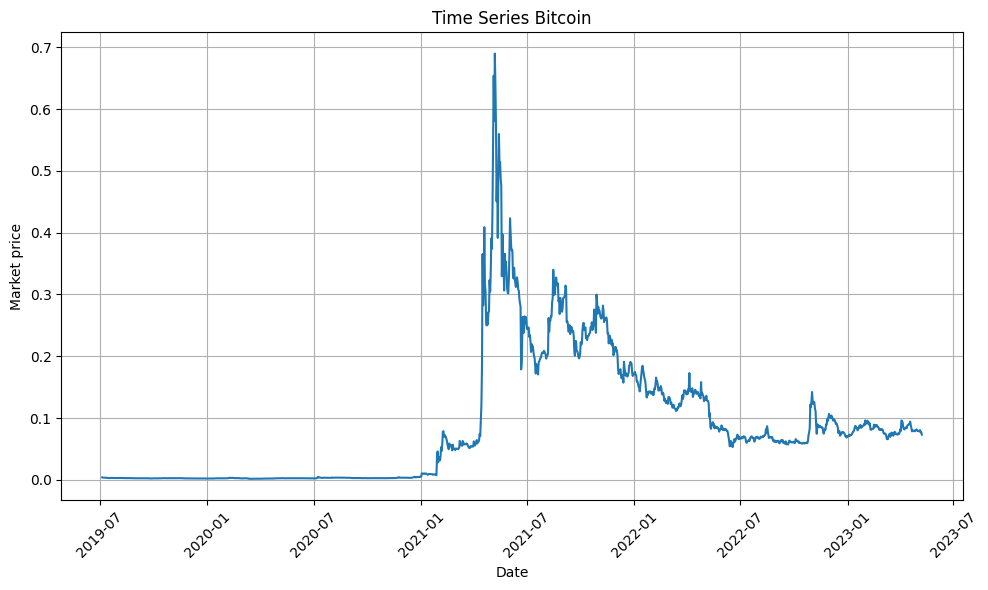

In [30]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(DOGE_Data.index, DOGE_Data['Close'], linestyle='-')  # Create the line plot
plt.title('Time Series Bitcoin')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Market price')  # Set the y-axis label
plt.grid(True)  # Show grid lines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

### Preliminary Analysis of the Bitcoin time-series

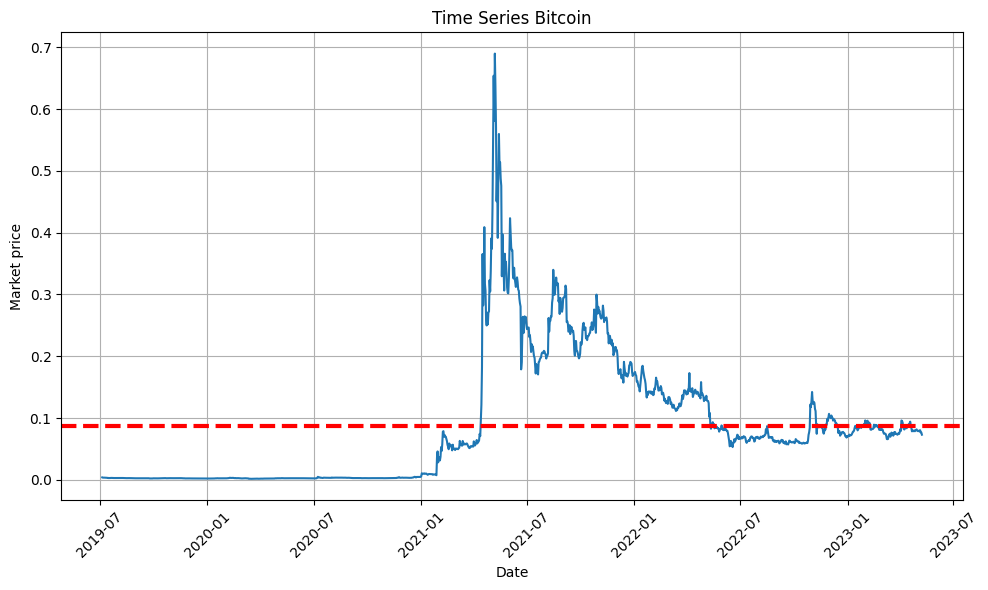

In [31]:
# create a time series plot with a mean line
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(DOGE_Data.index, DOGE_Data['Close'], linestyle='-')  # Create the line plot
plt.axhline(y=np.nanmean(DOGE_Data['Close']), color='red', linestyle='--', linewidth=3, label='Avg')
plt.title('Time Series Bitcoin')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
plt.ylabel('Market price')  # Set the y-axis label
plt.grid(True)  # Show grid lines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

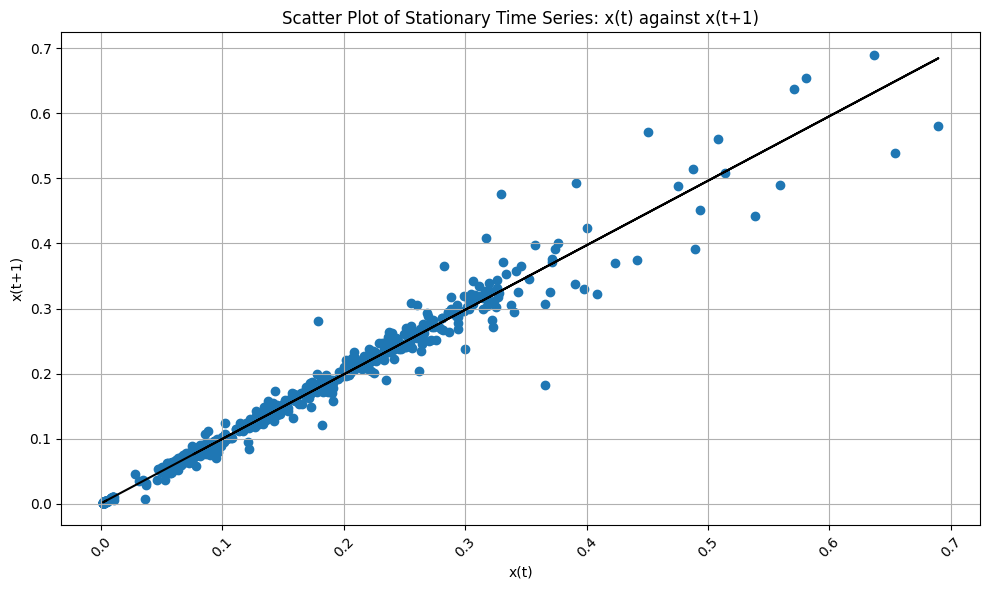

In [32]:
# make regression line between x(t) and x(t+1)
lr = LinearRegression()
lr.fit(np.array(DOGE_Data['Close'][:-1]).reshape(-1,1), DOGE_Data['Close'][1:])
y_pred = lr.predict(np.array(DOGE_Data['Close'][:-1]).reshape(-1,1))

# scatter plot between x(t) and x(t+1)
plt.figure(figsize=(10, 6))  # Set the figure size
plt.scatter(DOGE_Data['Close'][1:], DOGE_Data['Close'][:-1])  # Create the scatter plot
plt.plot(DOGE_Data['Close'][:-1], y_pred, color='k') #LinearRegression plot
plt.title('Scatter Plot of Stationary Time Series: x(t) against x(t+1)')  # Set the title
plt.xlabel('x(t)')  # Set the x-axis label
plt.ylabel('x(t+1)')  # Set the y-axis label
plt.grid(True)  # Show grid lines
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels 

# Show the plot
plt.show()

### shows positive correlation

#### Addressing the Seasonality, Trends of TS

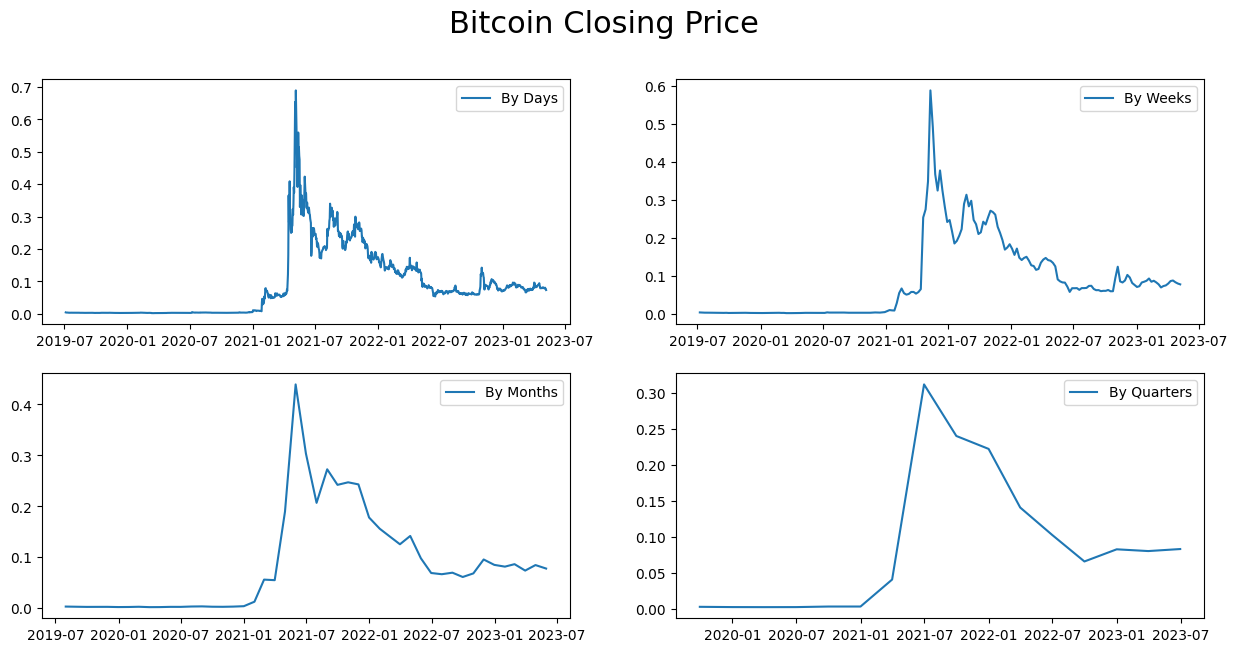

In [33]:
df = DOGE_Data[["Close"]]
# resampling to daily, monthly, annual and quarterly frequency
df = df.resample('D').mean()
df_month = df.resample('M').mean()
df_year = df.resample('A-DEC').mean()
df_Q = df.resample('Q-DEC').mean()
df_week = df.resample('W-MON').mean()

# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin Closing Price', fontsize=22)

plt.subplot(221)
plt.plot(df.Close, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_week.Close, '-', label='By Weeks')
plt.legend()

plt.subplot(223)
plt.plot(df_month.Close, '-', label='By Months')
plt.legend()

plt.subplot(224)
plt.plot(df_Q.Close, '-', label='By Quarters')
plt.legend()

# plt.subplot(224)
# plt.plot(df_year.Close, '-', label='By Years')
# plt.legend()

# plt.tight_layout()
plt.show()

#### Stationarity check and STL-decomposition of the series

Is the model an additive or multiplicative model? How to interpret this?

Dickey–Fuller test: p=0.267553


<Figure size 1500x700 with 0 Axes>

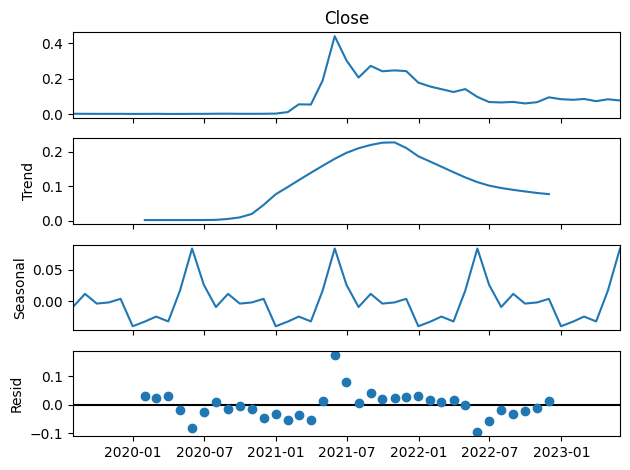

In [34]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close, model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

Taking into account the trends and seasonal behaviour, the series does not look stationary as the values depend upon the timeframe. In terms of residuals, this also does not looks stationary (looks like it has a pattern and is not random in my opinion). Thus, overall, this is a non stationary timeseries.

Dickey–Fuller test: p=0.267553


<Figure size 1500x700 with 0 Axes>

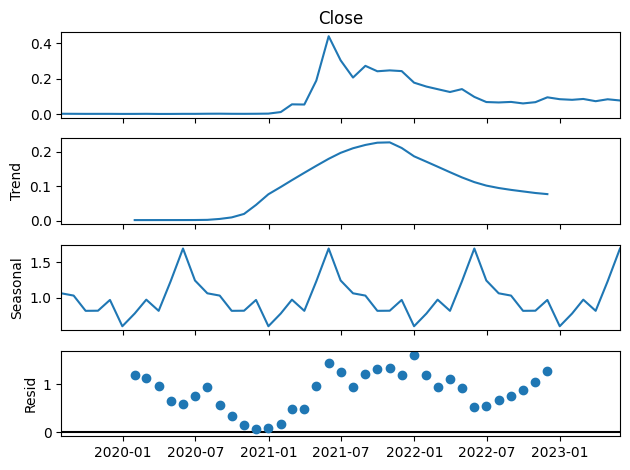

In [35]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Close, model="multiplicative").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Close)[1])
plt.show()

For the multiplicative model, the residuals look random, thus, (in my opinion), it can be considered stationary

Overall: The presence of trend and seasonal component in the Time Series makes it non-stationary and thus, differencing would be required to make it stationary. The presence of seasonality also means we can use the Seasonality based models (eg. SARIMA).

Dickey–Fuller test: p=0.362765


<Figure size 1500x700 with 0 Axes>

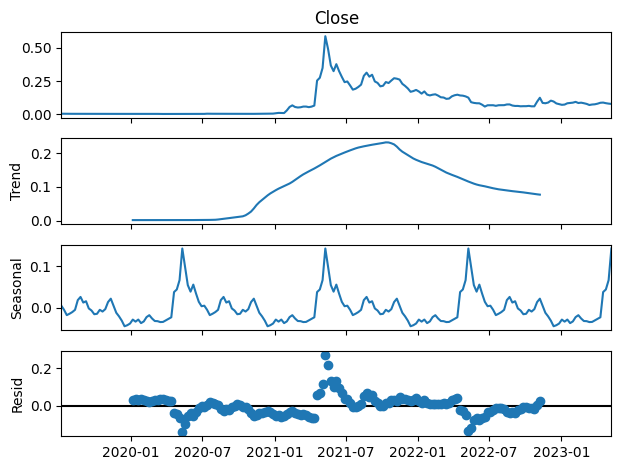

In [36]:
# predicting by weeks
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_week.Close, model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close)[1])
plt.show()

We notice yearly seasonality here.

Dickey–Fuller test: p=0.362765


<Figure size 1500x700 with 0 Axes>

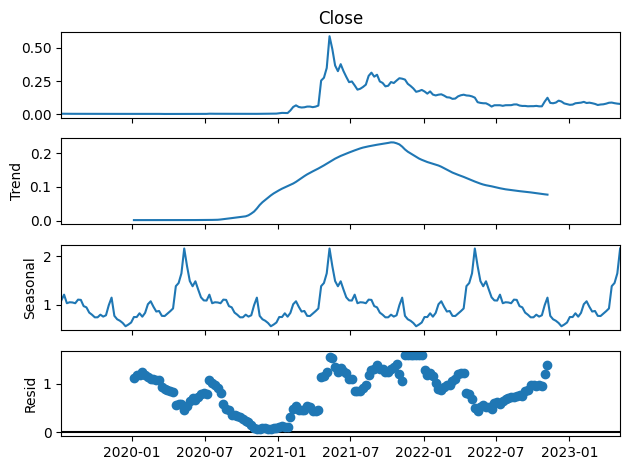

In [37]:
# predicting by weeks
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_week.Close, model="multiplicative").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close)[1])
plt.show()

#### Transformations

p-value needs to be as little as possible, preferably alpha<0.05, for stationarity

On a time series plot, the analyst sees that the difference between the high and low seasonal peaks grows over time. This pattern indicates that the variance is not stationary. The analyst performs a Box-Cox transformation to make the variance stationary before the analyst fits the ARIMA model. - in the current case, variance increases and decreases- is box transformation really necessary?

In [38]:
# Box-Cox Transformations
df_week['Close_box'], lmbda = stats.boxcox(df_week.Close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close)[1])
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.Close_box)[1])

Dickey–Fuller test: p=0.362765
Dickey–Fuller test: p=0.468230


Dickey–Fuller test: p=0.000000


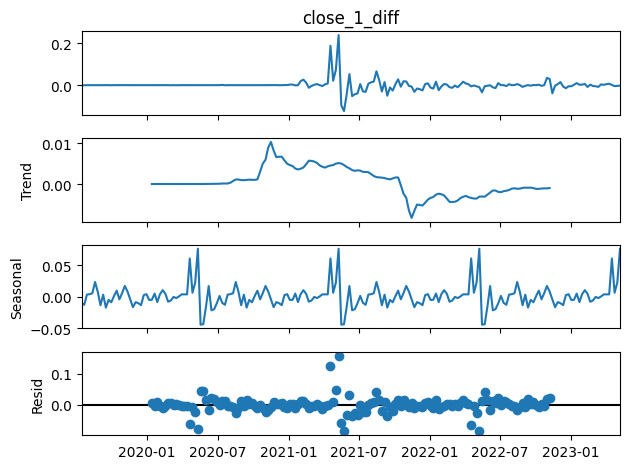

In [39]:
# Single differentiation wo box transformation - can be used for a simple ARIMA model.
df_week['close_1_diff'] = df_week.Close - df_week.Close.shift(1)
sm.tsa.seasonal_decompose(df_week.close_1_diff[1:], model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.close_1_diff[1:])[1])
# the variance seems to be increasing here

Dickey–Fuller test: p=0.061942


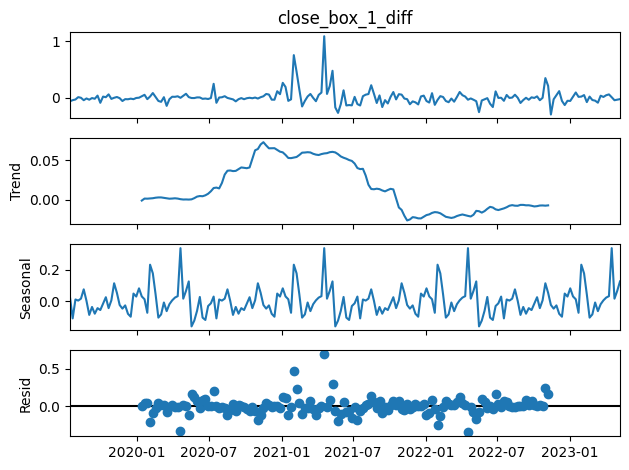

In [40]:
# Single differentiation - can be used for ARIMA model with box transformation.
df_week['close_box_1_diff'] = df_week.Close_box - df_week.Close_box.shift(1)
sm.tsa.seasonal_decompose(df_week.close_box_1_diff[1:], model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.close_box_1_diff[1:])[1])
# no increasing variance here

Dickey–Fuller test: p=0.310639


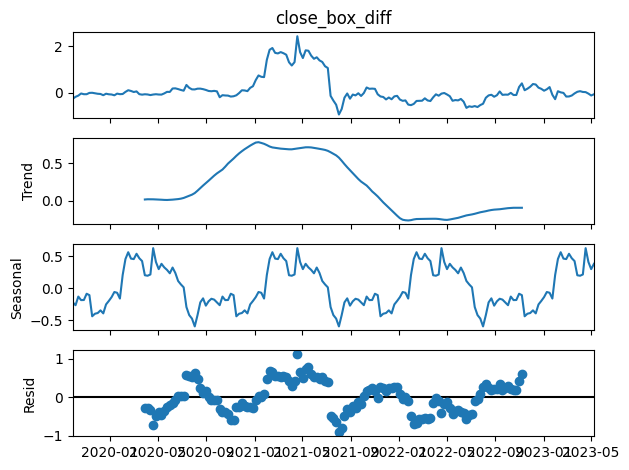

In [41]:
# Seasonal differentiation - can be used for SARIMA Model
df_week['close_box_diff'] = df_week.Close_box - df_week.Close_box.shift(12)
sm.tsa.seasonal_decompose(df_week.close_box_diff[12:], model="additive").plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_week.close_box_diff[12:])[1])

This is stationary

#### Computing the ACF and PACF - for the stationary time series

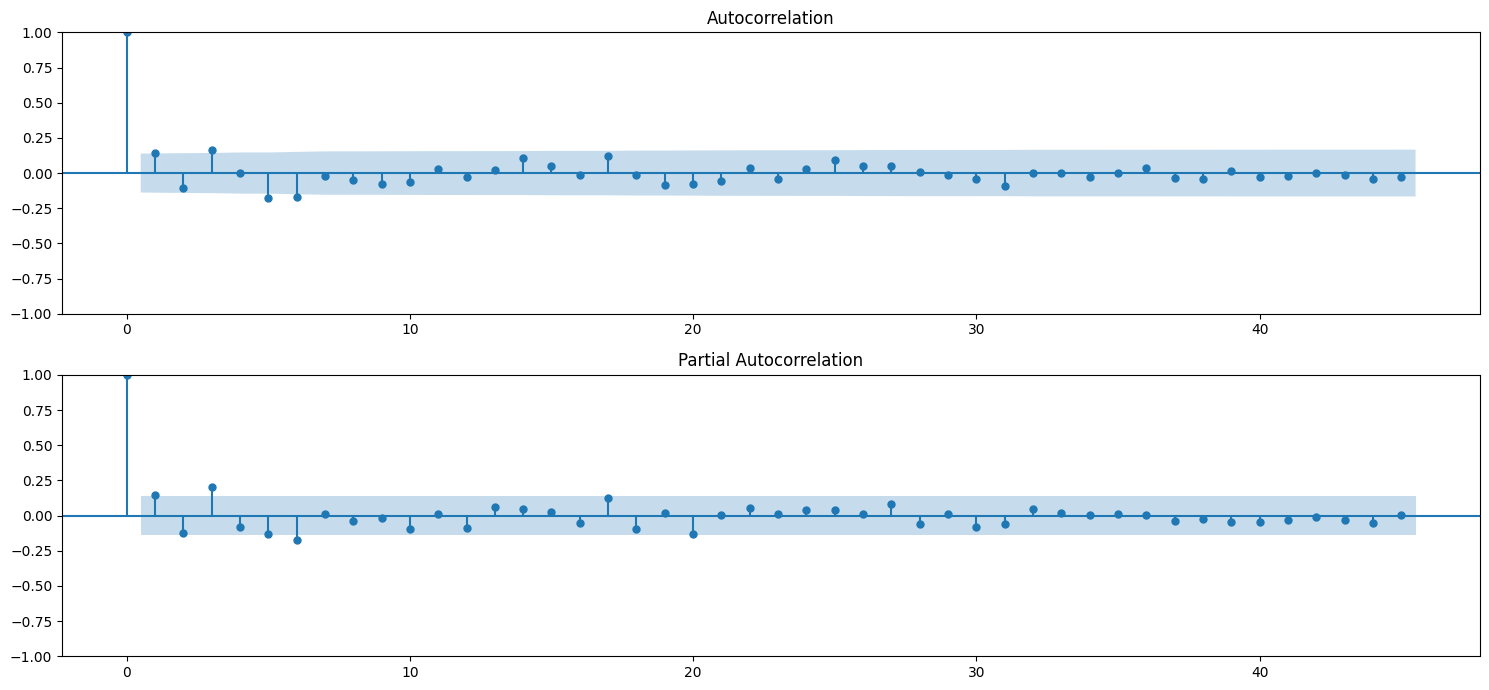

In [42]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_week.close_1_diff[1:].values.squeeze(), lags=45, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_week.close_1_diff[1:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

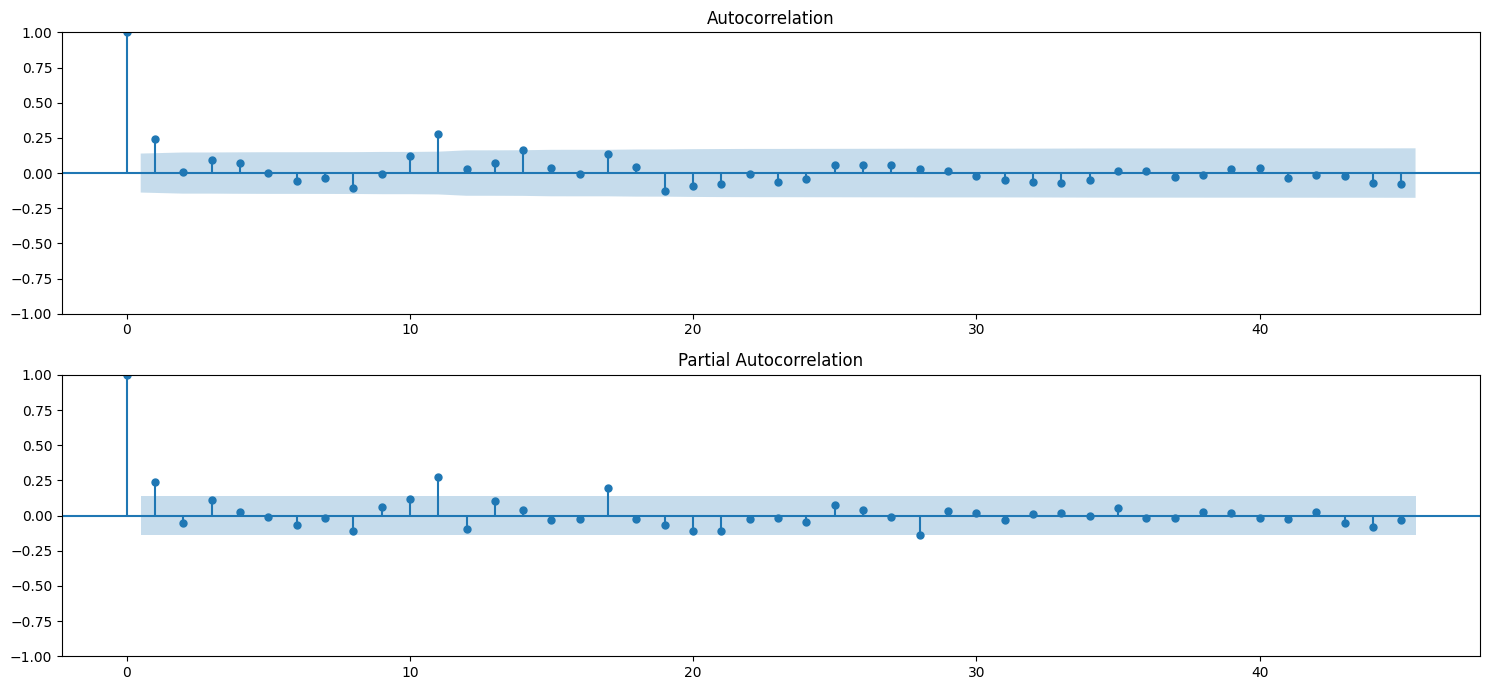

In [43]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots - best and simplest model?
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_week.close_box_1_diff[1:].values.squeeze(), lags=45, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_week.close_box_1_diff[1:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

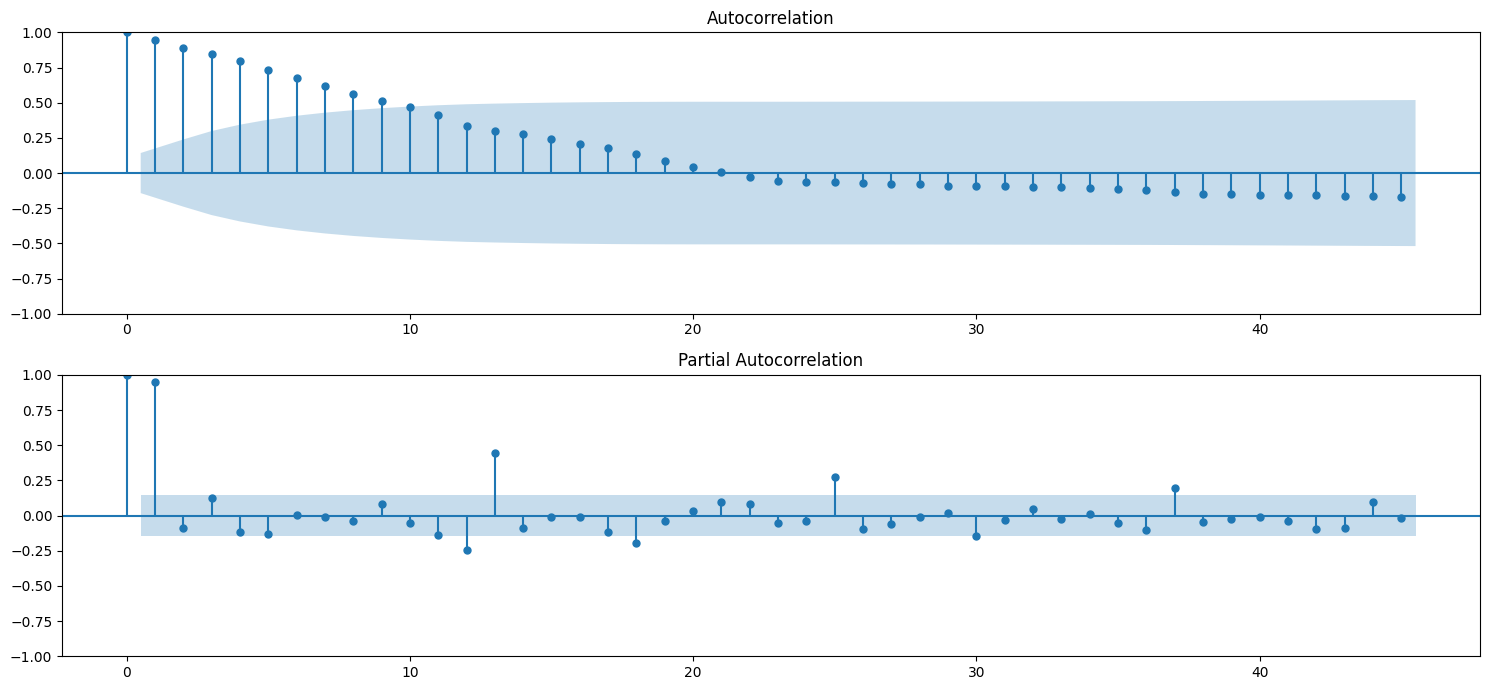

In [44]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_week.close_box_diff[12:].values.squeeze(), lags=45, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_week.close_box_diff[12:].values.squeeze(), lags=45, ax=ax)
plt.tight_layout()
plt.show()

In [45]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(df_week.close_box_1_diff[1:], lags=10)

,lb_stat,lb_pvalue
1,11.619338,0.000653
2,11.622828,0.002993
3,13.353417,0.003931
4,14.373863,0.006193
5,14.376281,0.013388
6,15.098826,0.019502
7,15.348056,0.031788
8,17.711488,0.023497
9,17.720579,0.038557
10,20.813366,0.022433


#### Modelling the series

In [46]:
# using the ARIMA Model on Untransformed Shift 1 data
ps = (0,1,2,3,4)
qs = (0,1,2,3,4)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        arima_model=ARIMA(df_week.Close, order=(param[0], d, param[1]))
        model = arima_model.fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_1 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model_1.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/states

   parameters         aic
14     (2, 4) -869.078556
6      (1, 1) -868.668969
9      (1, 4) -868.426706
19     (3, 4) -867.767289
18     (3, 3) -867.704801
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  201
Model:                 ARIMA(2, 1, 4)   Log Likelihood                 441.539
Date:                Tue, 10 Oct 2023   AIC                           -869.079
Time:                        16:51:42   BIC                           -845.990
Sample:                    07-08-2019   HQIC                          -859.735
                         - 05-08-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9469      0.177      5.357      0.000

Dickey–Fuller test:: p=0.000000


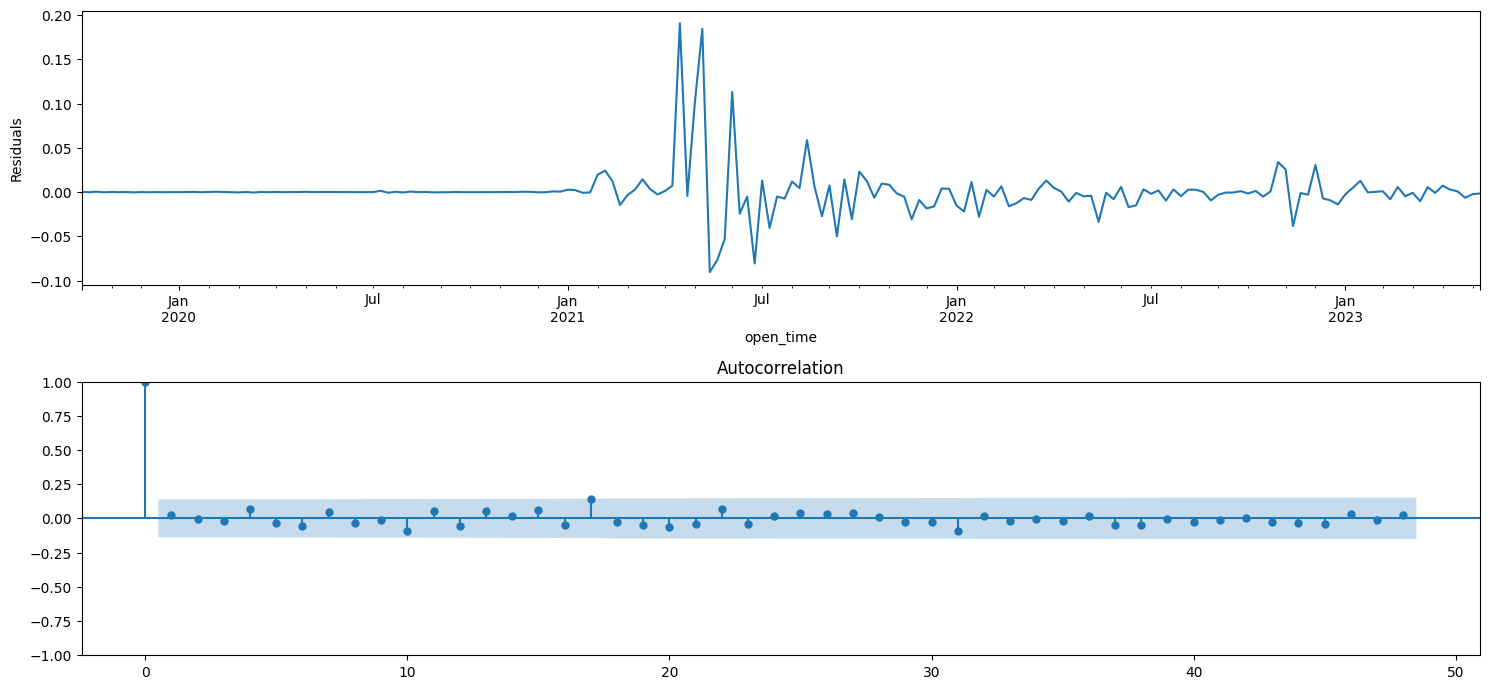

In [47]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model_1.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_1.resid[1:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model_1.resid[1:])[1])

plt.tight_layout()
plt.show()

In [48]:
# using the ARIMA Model on Box-transformed Shift 1 data
ps = (0,1,2)
qs = (0,1,2)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        arima_model=ARIMA(df_week.Close_box, order=(param[0], d, param[1]))
        model = arima_model.fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_2 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model_2.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  parameters         aic
7     (2, 1) -250.483307
8     (2, 2) -248.685193
1     (0, 1) -248.589556
3     (1, 0) -247.394517
4     (1, 1) -246.865553
                               SARIMAX Results                                
Dep. Variable:              Close_box   No. Observations:                  201
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 129.242
Date:                Tue, 10 Oct 2023   AIC                           -250.483
Time:                        16:51:44   BIC                           -237.290
Sample:                    07-08-2019   HQIC                          -245.144
                         - 05-08-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6671      0.051    -12.966      0.000      

Dickey–Fuller test:: p=0.000000


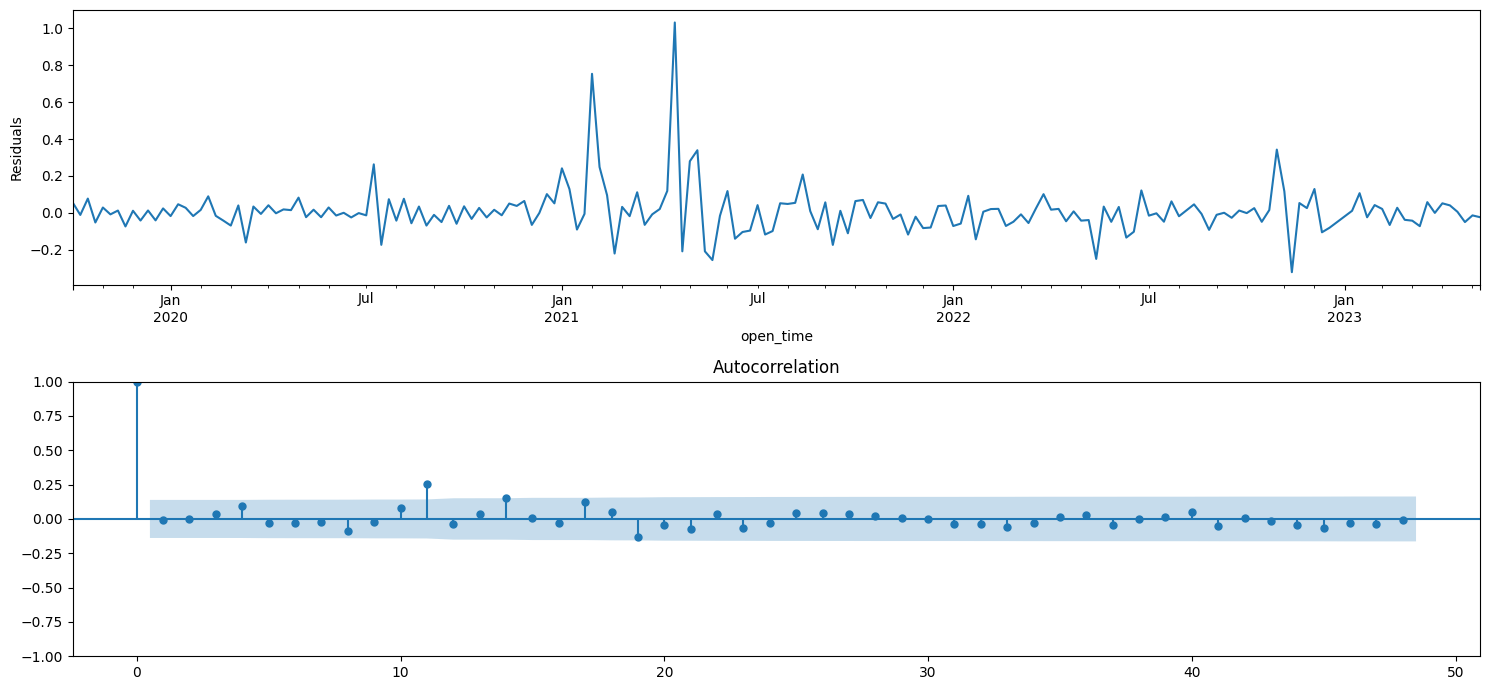

In [49]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model_2.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_2.resid[1:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model_2.resid[13:])[1])

plt.tight_layout()
plt.show()

In [50]:
# using the ARIMA Model on Box-transformed Seasonal Shift
ps = range(0,3)
qs = range(0,3)
d = 1
D = 1
Ps = range(0,3)
Qs = range(0,3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_week.Close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model_3 = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model_3.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximu

      parameters         aic
64  (2, 1, 0, 1) -193.961816
46  (1, 2, 0, 1) -193.734004
10  (0, 1, 0, 1) -193.301964
73  (2, 2, 0, 1) -192.390449
28  (1, 0, 0, 1) -192.289062
                                     SARIMAX Results                                      
Dep. Variable:                          Close_box   No. Observations:                  201
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 101.981
Date:                            Tue, 10 Oct 2023   AIC                           -193.962
Time:                                    16:55:04   BIC                           -177.780
Sample:                                07-08-2019   HQIC                          -187.405
                                     - 05-08-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.068967


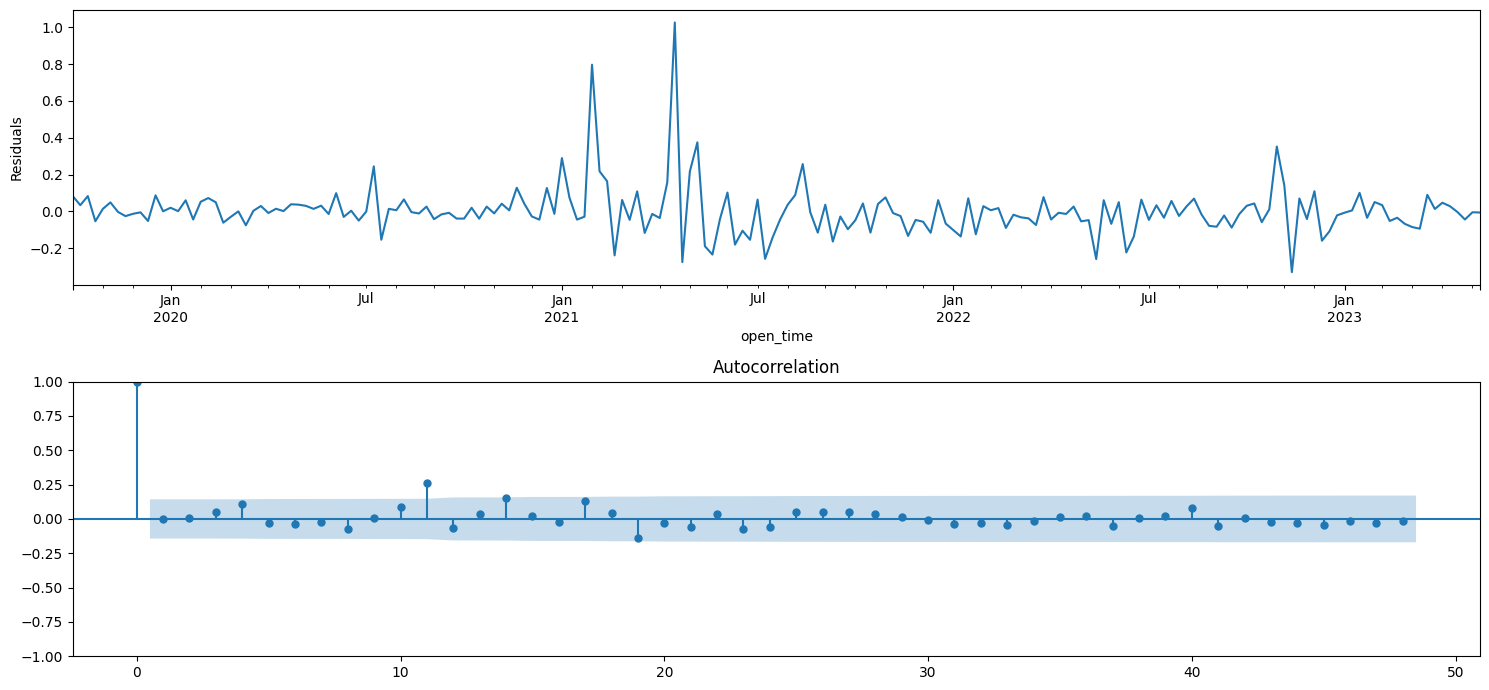

In [51]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model_3.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model_3.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model_3.resid[13:])[1])

plt.tight_layout()
plt.show()

#### Model Forecasting

In [52]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

/var/folders/2y/x00pyx115dl4rz225kttc1pw0000gn/T/ipykernel_30880/1192123877.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week2['forecast'] = best_model_1.predict(start=0, end=df_week2.shape[0])


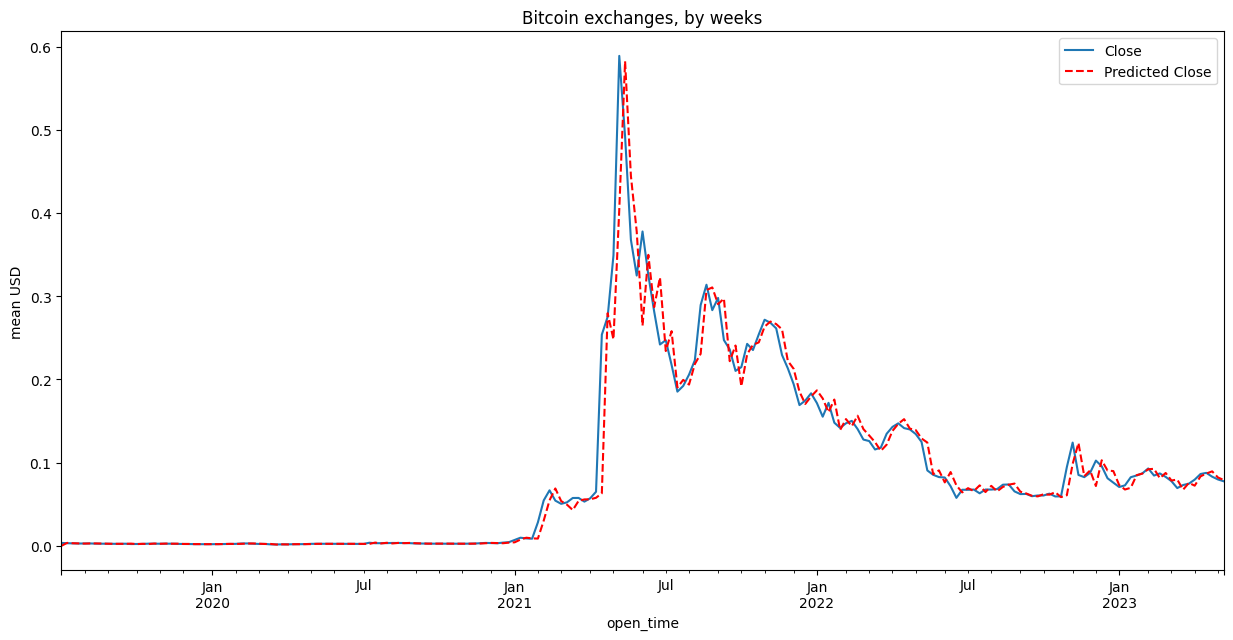

Root Mean Squared Error = 0.026507329364117694
R2 Score = 0.9341915156992063


In [53]:
# Prediction - best_model 1
df_week2 = df_week[['Close']]
df_week2['forecast'] = best_model_1.predict(start=0, end=df_week2.shape[0])
plt.figure(figsize=(15,7))
df_week2.Close.plot()
df_week2.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin exchanges, by weeks')
plt.ylabel('mean USD')
plt.show()
print(f"Root Mean Squared Error = {sqrt(mean_squared_error(df_week2.Close, df_week2.forecast))}")
print(f"R2 Score = {r2_score(df_week2.Close, df_week2.forecast)}")

/var/folders/2y/x00pyx115dl4rz225kttc1pw0000gn/T/ipykernel_30880/3987541203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week3['forecast'] = invboxcox(best_model_2.predict(start=0, end=df_week2.shape[0]), lmbda)


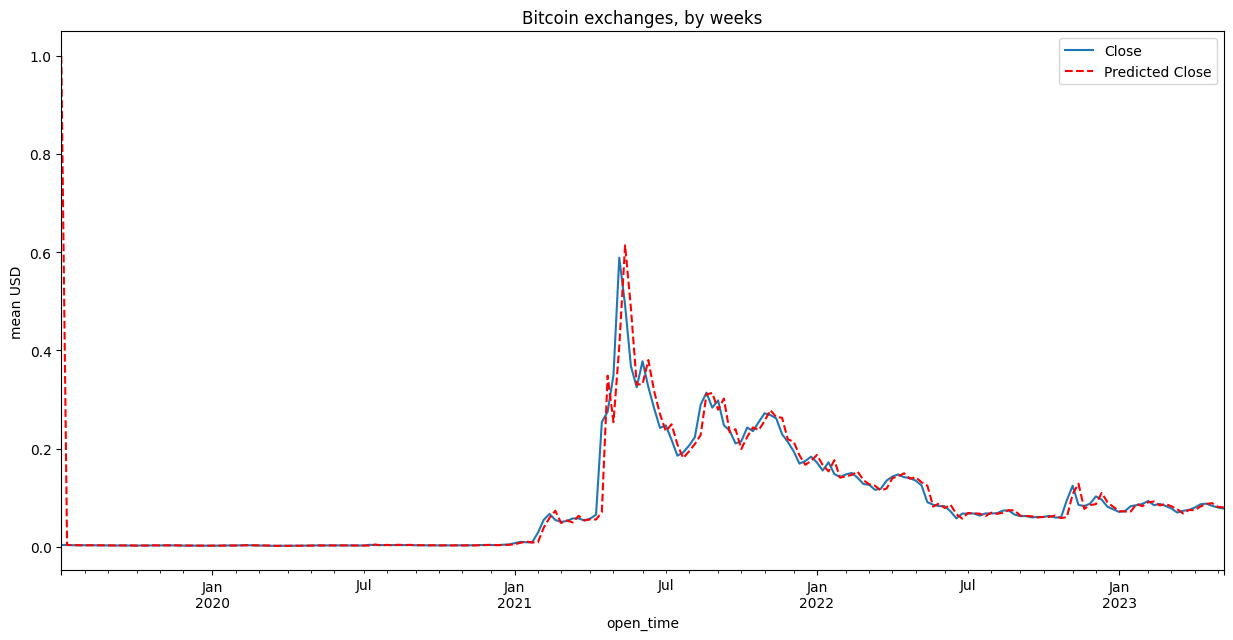

Root Mean Squared Error = 0.07510848701216823
R2 Score = 0.4716423903571889


In [54]:
# Prediction - best_model 2
df_week3 = df_week[['Close']]
df_week3['forecast'] = invboxcox(best_model_2.predict(start=0, end=df_week2.shape[0]), lmbda)
plt.figure(figsize=(15,7))
df_week3.Close.plot()
df_week3.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin exchanges, by weeks')
plt.ylabel('mean USD')
plt.show()
print(f"Root Mean Squared Error = {sqrt(mean_squared_error(df_week3.Close, df_week3.forecast))}")
print(f"R2 Score = {r2_score(df_week3.Close, df_week3.forecast)}")

/var/folders/2y/x00pyx115dl4rz225kttc1pw0000gn/T/ipykernel_30880/830105864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week4['forecast'] = invboxcox(best_model_3.predict(start=0, end=df_week2.shape[0]), lmbda)


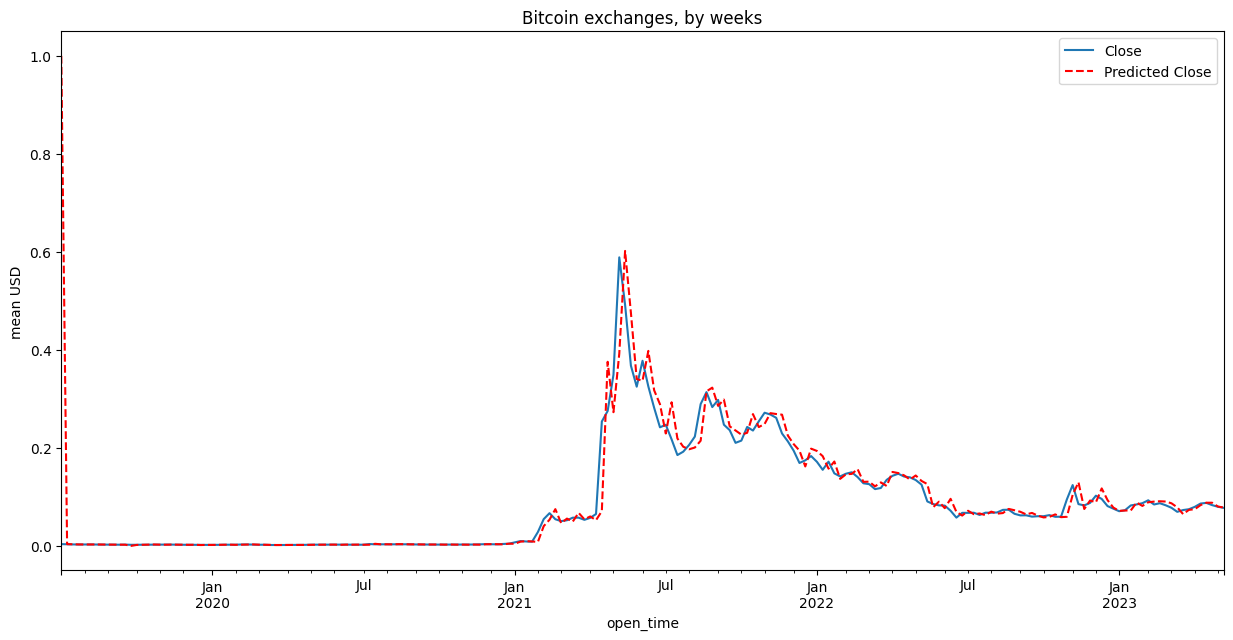

Root Mean Squared Error = 0.07566765131054137
R2 Score = 0.4637461203529666


In [55]:
# Prediction - best_model 3
df_week4 = df_week[['Close']]
df_week4['forecast'] = invboxcox(best_model_3.predict(start=0, end=df_week2.shape[0]), lmbda)
plt.figure(figsize=(15,7))
df_week4.Close.plot()
df_week4.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin exchanges, by weeks')
plt.ylabel('mean USD')
plt.show()
print(f"Root Mean Squared Error = {sqrt(mean_squared_error(df_week4.Close, df_week4.forecast))}")
print(f"R2 Score = {r2_score(df_week4.Close, df_week4.forecast)}")